In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### FitNets

In this notebook, we will implement FitNets method based on the paper https://arxiv.org/abs/1412.6550

Quoted from the paper,

``` We propose a novel approach to train thin and deep networks, called FitNets, to compress wide and shallower (but still deep) networks. ```

In this notebook, the architecture of the teacher uses ResNet without bottleneck block. To compare with even deeper network, ResNet with pre-activations architecture is used to demonstrate projections for layers above 1000. (Hence using pre-activations to alleviate vanishing gradients)



In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.datasets as dst
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import argparse
import os
import time
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Building Functions

In [ ]:
import importlib.util
# Load your module
spec = importlib.util.spec_from_file_location("util", "/content/drive/My Drive/rnd/FitNets/util.py")
util = importlib.util.module_from_spec(spec)
spec.loader.exec_module(util)

Building Architecture

In [ ]:
spec = importlib.util.spec_from_file_location("network", "/content/drive/My Drive/rnd/FitNets/network_colab.py")
network = importlib.util.module_from_spec(spec)
spec.loader.exec_module(network)

Importing Functions and Architectures

In [ ]:
AverageMeter = util.AverageMeter
accuracy = util.accuracy
transform_time = util.transform_time
load_pretrained_model = util.load_pretrained_model
save_checkpoint = util.save_checkpoint
define_tsnet = network.define_tsnet

In [ ]:
def adjust_lr(optimizer, epoch):
  '''
  Function to create arrays of descending learning rate based on epoch
  '''
  scale   = 0.1
  lr = 0.1
  lr_list =  [lr] * 100
  lr_list += [lr*scale] * 50
  lr_list += [lr*scale*scale] * 50

  lr = lr_list[epoch-1]
  print('epoch: {}  lr: {}'.format(epoch, lr))
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

In [ ]:
def train(train_loader, nets, optimizer, criterions, epoch):
  '''
  Train the model
  '''
  batch_time    = AverageMeter()
  data_time     = AverageMeter()
  cls_losses    = AverageMeter()
  fitnet_losses = AverageMeter()
  top1          = AverageMeter()
  top5          = AverageMeter()

  snet = nets['snet']
  tnet = nets['tnet']

  criterionCls    = criterions['criterionCls']
  criterionFitnet = criterions['criterionFitnet']

  snet.train()

  end = time.time()
  for idx, (img, target) in enumerate(train_loader, start=1):
    data_time.update(time.time() - end)

    if cuda:
      img = img.cuda()
      target = target.cuda()

    _, _, _, rb3_s, output_s = snet(img)
    _, _, _, rb3_t, output_t = tnet(img)

    cls_loss = criterionCls(output_s, target)
    fitnet_loss  = criterionFitnet(rb3_s, rb3_t.detach()) * lambda_fitnet
    loss = cls_loss + fitnet_loss

    prec1, prec5 = accuracy(output_s, target, topk=(1,5))
    cls_losses.update(cls_loss.item(), img.size(0))
    fitnet_losses.update(fitnet_loss.item(), img.size(0))
    top1.update(prec1.item(), img.size(0))
    top5.update(prec5.item(), img.size(0))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    batch_time.update(time.time() - end)
    end = time.time()

    if idx % print_freq == 0:
      print('Epoch[{0}]:[{1:03}/{2:03}] '
          'Time:{batch_time.val:.4f} '
          'Data:{data_time.val:.4f}  '
          'Cls:{cls_losses.val:.4f}({cls_losses.avg:.4f})  '
          'Fitnet:{fitnet_losses.val:.4f}({fitnet_losses.avg:.4f})  '
          'prec@1:{top1.val:.2f}({top1.avg:.2f})  '
          'prec@5:{top5.val:.2f}({top5.avg:.2f})'.format(
          epoch, idx, len(train_loader), batch_time=batch_time, data_time=data_time,
          cls_losses=cls_losses, fitnet_losses=fitnet_losses, top1=top1, top5=top5))


In [ ]:
def test(test_loader, nets, criterions):
	'''
	Test the model
	'''
	cls_losses    = AverageMeter()
	fitnet_losses = AverageMeter()
	top1          = AverageMeter()
	top5          = AverageMeter()

	snet = nets['snet']
	tnet = nets['tnet']

	criterionCls    = criterions['criterionCls']
	criterionFitnet = criterions['criterionFitnet']

	snet.eval()

	end = time.time()
	for idx, (img, target) in enumerate(test_loader, start=1):
		if cuda:
			img = img.cuda()
			target = target.cuda()

		with torch.no_grad():
			_, _, _, rb3_s, output_s = snet(img)
			_, _, _, rb3_t, output_t = tnet(img)

		cls_loss = criterionCls(output_s, target)
		fitnet_loss  = criterionFitnet(rb3_s, rb3_t.detach()) * lambda_fitnet
		# fitnet_loss = criterionCls(output_t, target)

		prec1, prec5 = accuracy(output_s, target, topk=(1,5))
		cls_losses.update(cls_loss.item(), img.size(0))
		fitnet_losses.update(fitnet_loss.item(), img.size(0))
		top1.update(prec1.item(), img.size(0))
		top5.update(prec5.item(), img.size(0))

	f_l = [cls_losses.avg, fitnet_losses.avg, top1.avg, top5.avg]
	print('Cls: {:.4f}, Fitnet: {:.4f}, Prec@1: {:.2f}, Prec@5: {:.2f}'.format(*f_l))
	return top1.avg

# FitNets ResNet20 students

In this first experiment, we will apply FitNets to ResNet-20 as the student.
Teacher has been trained and the student shall have its initializations before distilling the teacher model.

In [ ]:
t_model = "/content/drive/My Drive/rnd/FitNets/logs/checkpoint/baseline_preresnet110.pth.tar"
s_init = "/content/drive/My Drive/rnd/FitNets/logs/checkpoint/baseline_r20_000.pth.tar"
img_root = "/content/drive/My Drive/rnd/data"

In [ ]:
global print_freq, epochs, batch_size, lr, momentum, weight_decay, num_class
global data_name, t_name, s_name, lambda_fitnet, save_root
print_freq = 10
# epochs = 200
epochs = 1
batch_size = 64
lr = 0.1
momentum = 0.9
weight_decay = 1e-4
num_class = 10
cuda = 1
data_name = 'cifar10'
# t_name = 'resnet56'
t_name = 'preresnet110'

s_name = 'resnet20'
lambda_fitnet = 0.1

save_root ='/content/drive/My Drive/rnd/FitNets/logs/'

Initialize both teacher and student from the imported architecture module.

In [ ]:
	print('----------- Network Initialization --------------')
	snet = define_tsnet(name=s_name, num_class=num_class, cuda=cuda)
	checkpoint = torch.load(s_init)
	load_pretrained_model(snet, checkpoint['net'])
	# load_pretrained_model(snet, checkpoint['snet'])

	tnet = define_tsnet(name=t_name, num_class=num_class, cuda=cuda)
	checkpoint = torch.load(t_model)
	load_pretrained_model(tnet, checkpoint['state_dict'])
	tnet.eval()
	for param in tnet.parameters():
		param.requires_grad = False
	print('-----------------------------------------------')

----------- Network Initialization --------------
DataParallel(
  (module): resnet20(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (res1): Sequential(
      (0): resblock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): resblock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(in

Initialize optimizer, loss functions, train and test dataset

In [ ]:
# initialize optimizer
optimizer = torch.optim.SGD(snet.parameters(),
              lr = lr, 
              momentum = momentum, 
              weight_decay = weight_decay,
              nesterov = True)

# define loss functions
if cuda:
  criterionCls    = torch.nn.CrossEntropyLoss().cuda()
  criterionFitnet = torch.nn.MSELoss().cuda()
else:
  criterionCls    = torch.nn.CrossEntropyLoss()
  criterionFitnet = torch.nn.MSELoss()

# define transforms
if data_name == 'cifar10':
  dataset = dst.CIFAR10
  mean = (0.4914, 0.4822, 0.4465)
  std  = (0.2470, 0.2435, 0.2616)
elif data_name == 'cifar100':
  dataset = dst.CIFAR100
  mean = (0.5071, 0.4865, 0.4409)
  std  = (0.2673, 0.2564, 0.2762)
else:
  raise Exception('invalid dataset name...')

train_transform = transforms.Compose([
    transforms.Pad(4, padding_mode='reflect'),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
  ])
test_transform = transforms.Compose([
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
  ])

# define data loader
train_loader = torch.utils.data.DataLoader(
    dataset(root      = img_root,
        transform = train_transform,
        train     = True,
        download  = True),
    batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    dataset(root      = img_root,
        transform = test_transform,
        train     = False,
        download  = True),
    batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified


Distillation process

In [ ]:
top1_ = 0
for epoch in range(1, epochs+1):
  epoch_start_time = time.time()

  adjust_lr(optimizer, epoch)

  # train one epoch
  nets = {'snet':snet, 'tnet':tnet}
  criterions = {'criterionCls':criterionCls, 'criterionFitnet':criterionFitnet}
  train(train_loader, nets, optimizer, criterions, epoch)
  epoch_time = time.time() - epoch_start_time
  print('one epoch time is {:02}h{:02}m{:02}s'.format(*transform_time(epoch_time)))

  # evaluate on testing set
  print('testing the models......')
  test_start_time = time.time()
  top1 = test(test_loader, nets, criterions)
  test_time = time.time() - test_start_time
  print('testing time is {:02}h{:02}m{:02}s'.format(*transform_time(test_time)))

  # save model
  if top1 > top1_:
    print('saving models......')
    save_name = 'fitnet_pr110_r{}.pth.tar'.format(s_name[6:])
    save_name = os.path.join(save_root, 'checkpoint_fitnets', save_name)
    if epoch == 1:
      save_checkpoint({
        'epoch': epoch,
        'snet': snet.state_dict(),
        'tnet': tnet.state_dict(),
      }, save_name)
    else:
      save_checkpoint({
        'epoch': epoch,
        'snet': snet.state_dict(),
      }, save_name)
    top1_ = top1

epoch: 1  lr: 0.1
Epoch[1]:[010/782] Time:0.1203 Data:0.0001  Cls:1777257676800.0000(395314222899.8346)  Fitnet:71699445841920.0000(67518806045491.2031)  prec@1:6.25(11.41)  prec@5:39.06(50.62)
Epoch[1]:[020/782] Time:0.1246 Data:0.0001  Cls:1531805040640.0000(1231213315379.5171)  Fitnet:72494543273984.0000(68182247420723.2031)  prec@1:12.50(10.16)  prec@5:57.81(50.39)
Epoch[1]:[030/782] Time:0.1287 Data:0.0001  Cls:1987616047104.0000(1359555075345.2781)  Fitnet:63388189196288.0000(68289340514850.1328)  prec@1:7.81(9.64)  prec@5:59.38(50.42)
Epoch[1]:[040/782] Time:0.1230 Data:0.0001  Cls:3383385653248.0000(1732397153331.3586)  Fitnet:56473505759232.0000(66907253034188.7969)  prec@1:21.88(10.27)  prec@5:60.94(50.51)
Epoch[1]:[050/782] Time:0.1242 Data:0.0001  Cls:7286171369472.0000(1950865030389.8870)  Fitnet:83174164004864.0000(66398712296898.5625)  prec@1:15.62(10.75)  prec@5:56.25(51.78)
Epoch[1]:[060/782] Time:0.1258 Data:0.0001  Cls:2809854689280.0000(2133845009373.9724)  Fitnet:5

In [ ]:
def count_parameters(model):
    '''
    Function to count number of parameters in a model
    '''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(snet)

272474

# Fitnets to ResNet10 student

ResNet56 Teacher

In [ ]:
t_model = "/content/drive/My Drive/rnd/FitNets/logs/checkpoint/baseline_r56.pth.tar"

s_init = "/content/drive/My Drive/rnd/FitNets/logs/checkpoint/baseline_r10_000.pth.tar"

img_root = "/content/drive/My Drive/rnd/data"

In [ ]:
global print_freq, epochs, batch_size, lr, momentum, weight_decay, num_class
global data_name, t_name, s_name, lambda_fitnet, save_root
print_freq = 10
epochs = 200
# epochs = 1
batch_size = 64
lr = 0.1
momentum = 0.9
weight_decay = 1e-4
num_class = 10
cuda = 1
data_name = 'cifar10'
t_name = 'resnet56'

s_name = 'resnet10'
lambda_fitnet = 0.1

save_root ='/content/drive/My Drive/rnd/FitNets/logs/'

print('----------- Network Initialization --------------')
snet = define_tsnet(name=s_name, num_class=num_class, cuda=cuda)
checkpoint = torch.load(s_init)
# load_pretrained_model(snet, checkpoint['net'])
load_pretrained_model(snet, checkpoint['snet'])

tnet = define_tsnet(name=t_name, num_class=num_class, cuda=cuda)
checkpoint = torch.load(t_model)
load_pretrained_model(tnet, checkpoint['state_dict'])
tnet.eval()
for param in tnet.parameters():
  param.requires_grad = False
print('-----------------------------------------------')

----------- Network Initialization --------------
DataParallel(
  (module): resnet10(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (res1): Sequential(
      (0): resblock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): resblock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(in

In [ ]:
# initialize optimizer
optimizer = torch.optim.SGD(snet.parameters(),
              lr = lr, 
              momentum = momentum, 
              weight_decay = weight_decay,
              nesterov = True)

# define loss functions
if cuda:
  criterionCls    = torch.nn.CrossEntropyLoss().cuda()
  criterionFitnet = torch.nn.MSELoss().cuda()
else:
  criterionCls    = torch.nn.CrossEntropyLoss()
  criterionFitnet = torch.nn.MSELoss()

# define transforms
if data_name == 'cifar10':
  dataset = dst.CIFAR10
  mean = (0.4914, 0.4822, 0.4465)
  std  = (0.2470, 0.2435, 0.2616)
elif data_name == 'cifar100':
  dataset = dst.CIFAR100
  mean = (0.5071, 0.4865, 0.4409)
  std  = (0.2673, 0.2564, 0.2762)
else:
  raise Exception('invalid dataset name...')

train_transform = transforms.Compose([
    transforms.Pad(4, padding_mode='reflect'),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
  ])
test_transform = transforms.Compose([
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
  ])

# define data loader
train_loader = torch.utils.data.DataLoader(
    dataset(root      = img_root,
        transform = train_transform,
        train     = True,
        download  = True),
    batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    dataset(root      = img_root,
        transform = test_transform,
        train     = False,
        download  = True),
    batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
for epoch in range(1, epochs+1):
  epoch_start_time = time.time()

  adjust_lr(optimizer, epoch)

  # train one epoch
  nets = {'snet':snet, 'tnet':tnet}
  criterions = {'criterionCls':criterionCls, 'criterionFitnet':criterionFitnet}
  train(train_loader, nets, optimizer, criterions, epoch)
  epoch_time = time.time() - epoch_start_time
  print('one epoch time is {:02}h{:02}m{:02}s'.format(*transform_time(epoch_time)))

  # evaluate on testing set
  print('testing the models......')
  test_start_time = time.time()
  test(test_loader, nets, criterions)
  test_time = time.time() - test_start_time
  print('testing time is {:02}h{:02}m{:02}s'.format(*transform_time(test_time)))

  # save model
  print('saving models......')
  save_name = 'fitnet_r{}_r{}_{:>03}.pth.tar'.format(t_name[6:], s_name[6:], epoch)
  save_name = os.path.join(save_root, 'checkpoint_fitnets', save_name)
  if epoch == 1:
    save_checkpoint({
      'epoch': epoch,
      'snet': snet.state_dict(),
      'tnet': tnet.state_dict(),
    }, save_name)
  else:
    save_checkpoint({
      'epoch': epoch,
      'snet': snet.state_dict(),
    }, save_name)

Test reloading saved checkpoint

In [ ]:
s_init = "/content/drive/My Drive/rnd/FitNets/logs/checkpoint_fitnets/fitnet_r56_r10_200.pth.tar"

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(snet.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
## See result as it got disconnected
for epoch in range(1):
  epoch_start_time = time.time()

  adjust_lr(optimizer, epoch)

  # # train one epoch
  nets = {'snet':snet, 'tnet':tnet}
  criterions = {'criterionCls':criterion, 'criterionFitnet':criterionFitnet}

  # evaluate on testing set
  print('testing the models on GPU')
  print('FitNets criterion MSE Loss')
  test_start_time = time.time()
  test(test_loader, nets, criterions)
  test_time = time.time() - test_start_time
  print('testing time is {:02}h{:02}m{:02}s'.format(*transform_time(test_time)))

epoch: 0  lr: 0.0010000000000000002
testing the models on GPU
FitNets criterion MSE Loss
Cls: 13497.0220, Fitnet: 6788942.2056, Prec@1: 77.89, Prec@5: 98.95
testing time is 0.0h0.0m7.608931303024292s


Graph

In [ ]:
f = open("/content/drive/My Drive/rnd/FitNets/fitnet_r56_r10.csv", mode='r')
f1 = f.readlines()
tdata = []

for s in f1:
  if "Prec@1" not in s:
    continue
  else:
    # e_ = s.split("@1:")[0].split(":")[0]
    # epoch = np.int(e_[e_.index('[')+1:e_.index(']')])
    acc = np.float64(s.split("@1: ")[1][:5].split("(")[0])
    tdata.append([acc])
# print(tdata)

# print(tdata)
column = ["Accuracy"]
df = pd.DataFrame(tdata, columns=column)
print(df)

     Accuracy
0       16.06
1       17.72
2       18.89
3       17.20
4       26.52
..        ...
195     77.44
196     84.56
197     82.91
198     82.42
199     77.89

[200 rows x 1 columns]


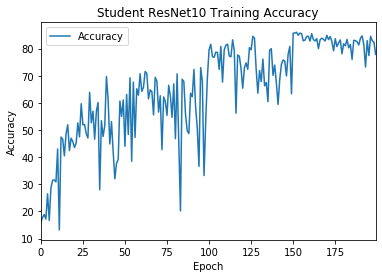

In [ ]:
ax = df.plot(title="Student ResNet10 Training Accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
plt.show()

# FitNets to ResNet1 Student

ResNet56 Teacher

In [ ]:
t_model = "/content/drive/My Drive/rnd/FitNets/logs/checkpoint/baseline_r56.pth.tar"

# s_init = "/content/drive/My Drive/rnd/FitNets/logs/checkpoint/baseline_r1_000.pth.tar"
s_init = "/content/drive/My Drive/rnd/FitNets/logs/checkpoint_fitnets/fitnet_r56_r1_050.pth.tar"

img_root = "/content/drive/My Drive/rnd/data"

In [ ]:
global print_freq, epochs, batch_size, lr, momentum, weight_decay, num_class
global data_name, t_name, s_name, lambda_fitnet, save_root
print_freq = 10
epochs = 200
# epochs = 1
batch_size = 64
lr = 0.1
momentum = 0.9
weight_decay = 1e-4
num_class = 10
cuda = 0
data_name = 'cifar10'
t_name = 'resnet56'

s_name = 'resnet1'
lambda_fitnet = 0.1

save_root ='/content/drive/My Drive/rnd/FitNets/logs/'

print('----------- Network Initialization --------------')
snet = define_tsnet(name=s_name, num_class=num_class, cuda=cuda)
checkpoint = torch.load(s_init)
# checkpoint = torch.load(s_init, map_location='cpu')
# load_pretrained_model(snet, checkpoint['net'])
load_pretrained_model(snet, checkpoint['snet'])

tnet = define_tsnet(name=t_name, num_class=num_class, cuda=cuda)
checkpoint = torch.load(t_model)
# checkpoint = torch.load(t_model,map_location='cpu')
load_pretrained_model(tnet, checkpoint['state_dict'])
tnet.eval()
for param in tnet.parameters():
  param.requires_grad = False
print('-----------------------------------------------')

----------- Network Initialization --------------
resnet1(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (res1): Sequential(
    (0): resblock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (res2): Sequential(
    (0): resblock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (ds): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, moment

In [ ]:
# initialize optimizer
optimizer = torch.optim.SGD(snet.parameters(),
              lr = lr, 
              momentum = momentum, 
              weight_decay = weight_decay,
              nesterov = True)

# define loss functions
if cuda:
  criterionCls    = nn.CrossEntropyLoss().cuda()
  criterionFitnet = nn.MSELoss().cuda()
  # criterionFitnet = nn.CrossEntropyLoss.cuda()
else:
  criterionCls    = nn.CrossEntropyLoss()
  criterionFitnet = nn.MSELoss()
  # criterionFitnet = nn.CrossEntropyLoss()

# define transforms
if data_name == 'cifar10':
  dataset = dst.CIFAR10
  mean = (0.4914, 0.4822, 0.4465)
  # std  = (0.2470, 0.2435, 0.2616)
  std = (0.2023, 0.1994, 0.2010)
elif data_name == 'cifar100':
  dataset = dst.CIFAR100
  mean = (0.5071, 0.4865, 0.4409)
  std  = (0.2673, 0.2564, 0.2762)
else:
  raise Exception('invalid dataset name...')

train_transform = transforms.Compose([
    transforms.Pad(4, padding_mode='reflect'),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
  ])
test_transform = transforms.Compose([
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
  ])

# define data loader
train_loader = torch.utils.data.DataLoader(
    dataset(root      = img_root,
        transform = train_transform,
        train     = True,
        download  = True),
    batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    dataset(root      = img_root,
        transform = test_transform,
        train     = False,
        download  = True),
    batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
for epoch in range(1, epochs+1):
  epoch_start_time = time.time()

  adjust_lr(optimizer, epoch)

  # train one epoch
  nets = {'snet':snet, 'tnet':tnet}
  criterions = {'criterionCls':criterionCls, 'criterionFitnet':criterionFitnet}
  train(train_loader, nets, optimizer, criterions, epoch)
  epoch_time = time.time() - epoch_start_time
  print('one epoch time is {:02}h{:02}m{:02}s'.format(*transform_time(epoch_time)))

  # evaluate on testing set
  print('testing the models......')
  test_start_time = time.time()
  test(test_loader, nets, criterions)
  test_time = time.time() - test_start_time
  print('testing time is {:02}h{:02}m{:02}s'.format(*transform_time(test_time)))

  # save model
  print('saving models......')
  save_name = 'fitnet_r{}_r{}_{:>03}.pth.tar'.format(t_name[6:], s_name[6:], epoch)
  save_name = os.path.join(save_root, 'checkpoint_fitnets', save_name)
  if epoch == 1:
    save_checkpoint({
      'epoch': epoch,
      'snet': snet.state_dict(),
      'tnet': tnet.state_dict(),
    }, save_name)
  else:
    save_checkpoint({
      'epoch': epoch,
      'snet': snet.state_dict(),
      'optimizer' : optimizer.state_dict(),
    }, save_name)

epoch: 1  lr: 0.1
Epoch[1]:[010/782] Time:0.6753 Data:0.0002  Cls:673999.1250(474181.2313)  Fitnet:8614623.0000(8984588.9000)  prec@1:15.62(10.00)  prec@5:59.38(51.09)
Epoch[1]:[020/782] Time:0.6736 Data:0.0002  Cls:542188.8750(502039.2594)  Fitnet:9366697.0000(8751187.9250)  prec@1:10.94(10.55)  prec@5:45.31(50.62)
Epoch[1]:[030/782] Time:0.6856 Data:0.0002  Cls:469705.2188(488314.2443)  Fitnet:8273408.0000(8706442.2333)  prec@1:12.50(10.52)  prec@5:48.44(50.26)
Epoch[1]:[040/782] Time:0.6666 Data:0.0002  Cls:543451.8125(478983.3301)  Fitnet:8801831.0000(8678863.7625)  prec@1:15.62(10.27)  prec@5:56.25(50.55)
Epoch[1]:[050/782] Time:0.6708 Data:0.0002  Cls:575159.9375(472116.0875)  Fitnet:8065100.0000(8567821.8200)  prec@1:12.50(10.72)  prec@5:64.06(51.59)
Epoch[1]:[060/782] Time:0.6723 Data:0.0002  Cls:485224.0000(495312.0146)  Fitnet:7946854.5000(8557601.5667)  prec@1:21.88(11.28)  prec@5:65.62(52.45)
Epoch[1]:[070/782] Time:0.6780 Data:0.0002  Cls:1566131.1250(522975.5362)  Fitnet:

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in 

KeyboardInterrupt: ignored

^^ up there is a ten hours training, make sure dont mess it up

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(snet.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
## See result as it got disconnected
for epoch in range(1):
  epoch_start_time = time.time()

  adjust_lr(optimizer, epoch)

  # # train one epoch
  nets = {'snet':snet, 'tnet':tnet}
  criterions = {'criterionCls':criterion, 'criterionFitnet':criterionFitnet}

  # evaluate on testing set
  print('testing the models on CPU')
  print('FitNets criterion Cross Entropy Loss')
  test_start_time = time.time()
  test(test_loader, nets, criterions)
  test_time = time.time() - test_start_time
  print('testing time is {:02}h{:02}m{:02}s'.format(*transform_time(test_time)))

epoch: 0  lr: 0.0010000000000000002
testing the models on CPU
FitNets criterion Cross Entropy Loss
Cls: 2.3788, Fitnet: 10368.1978, Prec@1: 8.86, Prec@5: 52.00
testing time is 0.0h1.0m17.853076934814453s


In [ ]:
optimizer = torch.optim.SGD(snet.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
## See result as it got disconnected
for epoch in range(1):
  epoch_start_time = time.time()

  adjust_lr(optimizer, epoch)

  # # train one epoch
  nets = {'snet':snet, 'tnet':tnet}
  criterions = {'criterionCls':criterion, 'criterionFitnet':criterionFitnet}

  # evaluate on testing set
  print('testing the models on CPU')
  print('FitNets criterion MSE Loss')
  test_start_time = time.time()
  test(test_loader, nets, criterions)
  test_time = time.time() - test_start_time
  print('testing time is {:02}h{:02}m{:02}s'.format(*transform_time(test_time)))

epoch: 0  lr: 0.0010000000000000002
testing the models on CPU
FitNets criterion MSE Loss
Cls: 2.3788, Fitnet: 626021.4527, Prec@1: 8.86, Prec@5: 52.00
testing time is 0.0h1.0m18.879685163497925s


In [ ]:
optimizer = torch.optim.SGD(snet.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
## See result as it got disconnected
for epoch in range(1):
  epoch_start_time = time.time()

  adjust_lr(optimizer, epoch)

  # # train one epoch
  nets = {'snet':snet, 'tnet':tnet}
  criterions = {'criterionCls':criterionCls, 'criterionFitnet':criterionFitnet}

  # evaluate on testing set
  print('testing the models on GPU')
  print('FitNets criterion MSE Loss')
  test_start_time = time.time()
  test(test_loader, nets, criterions)
  test_time = time.time() - test_start_time
  print('testing time is {:02}h{:02}m{:02}s'.format(*transform_time(test_time)))

epoch: 0  lr: 0.0010000000000000002
testing the models on GPU
FitNets criterion MSE Loss
Cls: 4079150.2848, Fitnet: 6429530.2640, Prec@1: 63.06, Prec@5: 92.30
testing time is 0.0h1.0m11.709341287612915s


Graph

In [ ]:
f = open("/content/drive/My Drive/rnd/FitNets/fitnet_r56_r1.csv", mode='r')
f1 = f.readlines()
tdata = []

for s in f1:
  if "Prec@1" not in s:
    continue
  else:
    # e_ = s.split("@1:")[0].split(":")[0]
    # epoch = np.int(e_[e_.index('[')+1:e_.index(']')])
    acc = np.float64(s.split("@1: ")[1][:5].split("(")[0])
    tdata.append([acc])
# print(tdata)

# print(tdata)
column = ["Accuracy"]
df = pd.DataFrame(tdata, columns=column)
print(df)

    Accuracy
0      24.04
1      28.35
2      10.07
3      12.92
4      21.30
5      32.46
6      40.22
7      30.96
8      21.86
9      48.77
10     45.85
11     41.17
12     41.95
13     51.31
14     41.52
15     40.80
16     20.88
17     47.16
18     59.84
19     50.87
20     33.96
21     46.55
22     21.83
23     30.15
24     46.38
25     57.32
26     24.87
27     34.06
28     50.91
29     54.65
30     42.79
31     44.54
32     52.71
33     39.59
34     55.76
35     38.13
36     42.87
37     61.99
38     26.83
39     46.61
40     40.15
41     43.51
42     60.13
43     45.04
44     63.63
45     54.90
46     39.81
47     34.26
48     45.90
49     63.06
50     44.87
51     45.54
52     50.95


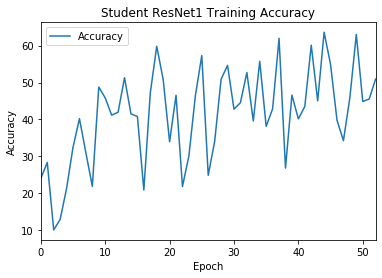

In [ ]:
ax = df.plot(title="Student ResNet1 Training Accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
plt.show()